# **Blood Cell Images**

## **Downloading data from Kaggle**

In [1]:
import os
os.environ['KAGGLE_USERNAME'] = "sushrutgaikwad"
os.environ['KAGGLE_KEY'] = "7d35f99822daf68b0a5cc2bc4756f94e"
! kaggle datasets download paultimothymooney/blood-cells

 96% 104M/108M [00:03<00:00, 33.1MB/s] 
100% 108M/108M [00:04<00:00, 28.2MB/s]


In [2]:
! unzip blood-cells.zip

Streaming output truncated to the last 5000 lines.
  inflating: dataset2-master/dataset2-master/images/TRAIN/LYMPHOCYTE/_9_8050.jpeg  
  inflating: dataset2-master/dataset2-master/images/TRAIN/LYMPHOCYTE/_9_8167.jpeg  
  inflating: dataset2-master/dataset2-master/images/TRAIN/LYMPHOCYTE/_9_8283.jpeg  
  inflating: dataset2-master/dataset2-master/images/TRAIN/LYMPHOCYTE/_9_8324.jpeg  
  inflating: dataset2-master/dataset2-master/images/TRAIN/LYMPHOCYTE/_9_8379.jpeg  
  inflating: dataset2-master/dataset2-master/images/TRAIN/LYMPHOCYTE/_9_8577.jpeg  
  inflating: dataset2-master/dataset2-master/images/TRAIN/LYMPHOCYTE/_9_8587.jpeg  
  inflating: dataset2-master/dataset2-master/images/TRAIN/LYMPHOCYTE/_9_8655.jpeg  
  inflating: dataset2-master/dataset2-master/images/TRAIN/LYMPHOCYTE/_9_8701.jpeg  
  inflating: dataset2-master/dataset2-master/images/TRAIN/LYMPHOCYTE/_9_872.jpeg  
  inflating: dataset2-master/dataset2-master/images/TRAIN/LYMPHOCYTE/_9_8864.jpeg  
  inflating: dataset2-mast

## **Checking if GPU is available**

In [3]:
!nvidia-smi

Sat Sep 25 11:42:04 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.63.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   68C    P8    31W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## **Importing Relevant Libraries**

In [4]:
import tensorflow as tf
print(tf.__version__)

2.6.0


In [5]:
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten, Conv2D,\
     BatchNormalization, ZeroPadding2D, MaxPooling2D, Activation, add
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam

from sklearn.metrics import confusion_matrix
import numpy as np
import matplotlib.pyplot as plt

from glob import glob

## **Preprocessing**

In [6]:
# Re-size all the images
IMAGE_SIZE=[224,224] # feel free to change this depending on the dataset

# Training configuration:
epochs=16
batch_size=128

In [7]:
train_path='/content/dataset2-master/dataset2-master/images/TRAIN'
valid_path='/content/dataset2-master/dataset2-master/images/TEST'

In [8]:
# Useful for getting number of files
image_files=glob(train_path+'/*/*.jp*g')
valid_image_files=glob(valid_path+'/*/*.jp*g')

In [9]:
# Useful for getting number of classes
folders=glob(train_path+'/*')

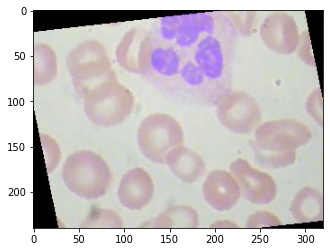

In [10]:
# Let's have a look at an image
plt.imshow(image.load_img(np.random.choice(image_files)))
plt.show()

## **Constructing the Model**
Here, we will construct the ResNet model. We won't be using the pretrained ResNet from tensorflow library.

### **Identity Block**
This function is for the identity block. Recall that a ResNet contains several Identity blocks. So, it will be useful to encapsulate all these layers into a single function.

In [11]:
def identity_block(input_, kernel_size, filters):
  f1, f2, f3 = filters # This means that the input argument "filters" must have size 3

  # Now we declare a series of convolutions, followed by batch norm, followed by ReLU. This is repeated twice
  x = Conv2D(f1, (1, 1))(input_)
  x = BatchNormalization()(x)
  x = Activation('relu')(x)

  x = Conv2D(f2, kernel_size, padding='same')(x)
  x = BatchNormalization()(x)
  x = Activation('relu')(x)

  x = Conv2D(f3, (1, 1))(x)
  x = BatchNormalization()(x)
  x = add([x, input_]) # This is where we add the shortcut branch
  x = Activation('relu')(x)
  return x

### **Convolution Block**
Again, since the convolution block appears several times in the ResNet, it is useful to encapsulate it in a function.

In [12]:
def conv_block(input_, kernel_size, filters, strides=(2, 2)):
  f1, f2, f3 = filters

  x = Conv2D(f1, (1, 1), strides=strides)(input_)
  x = BatchNormalization()(x)
  x = Activation('relu')(x)

  x = Conv2D(f2, kernel_size, padding='same')(x)
  x = BatchNormalization()(x)
  x = Activation('relu')(x)

  x = Conv2D(f3, (1, 1))(x)
  x = BatchNormalization()(x)

  shortcut = Conv2D(f3, (1, 1), strides=strides)(input_)
  shortcut = BatchNormalization()(shortcut)

  x = add([x, shortcut])
  x = Activation('relu')(x)
  return x

### **Our Custom ResNet**

In [13]:
# Our custom ResNet
i = Input(shape=IMAGE_SIZE+[3])
x = ZeroPadding2D(padding=(3, 3))(i)
x = Conv2D(64, (7, 7), strides=(2, 2), padding='valid')(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = ZeroPadding2D(padding=(1, 1))(x)
x = MaxPooling2D((3, 3), strides=(2, 2))(x)

x = conv_block(x, 3, [64, 64, 256], strides=(1, 1))
x = identity_block(x, 3, [64, 64, 256])
x = identity_block(x, 3, [64, 64, 256])

x = conv_block(x, 3, [128, 128, 512])
x = identity_block(x, 3, [128, 128, 512])
x = identity_block(x, 3, [128, 128, 512])
x = identity_block(x, 3, [128, 128, 512])

### **Continuing our Neural Network**

In [14]:
# Our layers
x = Flatten()(x)
# x = Dense(1000, activation='relu')(x)
# We can add more layers, just as shown above
prediction = Dense(len(folders), activation='softmax')(x)

In [15]:
# Create a model object
model = Model(inputs=i, outputs=prediction)

In [16]:
# View the structure of the model
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 112, 112, 64) 9472        zero_padding2d[0][0]             
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 112, 112, 64) 256         conv2d[0][0]                     
______________________________________________________________________________________________

In [17]:
# Tell the model what cost and optimization method to use
model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=Adam(learning_rate=0.0001),
    metrics=['accuracy']
)

#### **Image Preprocessing**
Recall that VGG and ResNet have their own ways of doing this. Since we have created our own neural network from scratch, we are not required to use those methods. So, in our function, what we will do is scale the pixel values to be between $-1$ and $+1$.

In [18]:
def preprocess_input2(x):
  x = x / 127.5
  x = x - 1.
  return x

### **Continuing with ImageDataGenerator**

In [19]:
train_gen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    preprocessing_function=preprocess_input2
)

val_gen = ImageDataGenerator(
    preprocessing_function=preprocess_input2
)

In [20]:
# test generator to see how it works and some other useful things

# get label mapping for confusion matrix plot later
test_gen = val_gen.flow_from_directory(valid_path, target_size=IMAGE_SIZE, class_mode='sparse')
print(test_gen.class_indices)
labels = [None] * len(test_gen.class_indices)
for k, v in test_gen.class_indices.items():
  labels[v] = k

Found 2487 images belonging to 4 classes.
{'EOSINOPHIL': 0, 'LYMPHOCYTE': 1, 'MONOCYTE': 2, 'NEUTROPHIL': 3}


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


min: -1.0 max: 1.0


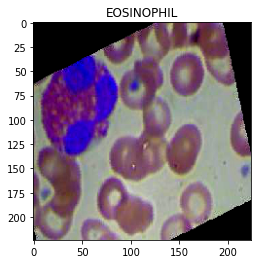

In [21]:
# Should NOT be a strangely coloured image, as opposed to using ResNet from tensorflow
for x, y in test_gen:
  print("min:", x[0].min(), "max:", x[0].max())
  plt.title(labels[np.argmax(y[0])])
  plt.imshow(x[0])
  plt.show()
  break

# The image doesn't appear strangely coloured since our preprocessing function
# doesn't switch the RGB channels like the other preprocessing functions
# we were using.

In [22]:
# create generators
train_generator = train_gen.flow_from_directory(
  train_path,
  target_size=IMAGE_SIZE,
  shuffle=True,
  batch_size=batch_size,
  class_mode='sparse'
)
valid_generator = val_gen.flow_from_directory(
  valid_path,
  target_size=IMAGE_SIZE,
  shuffle=True,
  batch_size=batch_size,
  class_mode='sparse'
)

Found 9957 images belonging to 4 classes.
Found 2487 images belonging to 4 classes.


## **Fitting the model**

In [23]:
# Fitting the model
checkpoint_filepath = '/tmp/checkpoint'
r = model.fit(
    train_generator,
    validation_data=valid_generator,
    epochs=epochs,
    steps_per_epoch=len(image_files) // batch_size,
    validation_steps=len(valid_image_files) // batch_size,
    callbacks=[
               tf.keras.callbacks.EarlyStopping(
                   monitor='loss', patience=3, restore_best_weights=True),
               tf.keras.callbacks.ModelCheckpoint(
                   filepath=checkpoint_filepath,
                   save_weights_only=True,
                   monitor='val_accuracy',
                   mode='max',
                   save_best_only=True)
               ]
              )


# Note that this time, we have included some callbacks. The first callback is
# for early stopping. So, if the loss fails to decrease sufficiently, the
# optimization will end.
# The second callback is to create a model checkpoint which will save our best
# model during the training process in terms of the validation accuracy. This
# is useful since as we will see, the loss and accuracy tend to jump around quite
# a bit

Epoch 1/16
77/77 [==============================] - 220s 2s/step - loss: 6.9845 - accuracy: 0.3000 - val_loss: 1.5614 - val_accuracy: 0.2492
Epoch 2/16
77/77 [==============================] - 180s 2s/step - loss: 1.8652 - accuracy: 0.5041 - val_loss: 1.8755 - val_accuracy: 0.2516
Epoch 3/16
77/77 [==============================] - 179s 2s/step - loss: 1.0638 - accuracy: 0.7201 - val_loss: 2.9894 - val_accuracy: 0.3470
Epoch 4/16
77/77 [==============================] - 178s 2s/step - loss: 0.7090 - accuracy: 0.8236 - val_loss: 10.5182 - val_accuracy: 0.2434
Epoch 5/16
77/77 [==============================] - 180s 2s/step - loss: 0.3753 - accuracy: 0.8979 - val_loss: 18.1228 - val_accuracy: 0.2611
Epoch 6/16
77/77 [==============================] - 179s 2s/step - loss: 0.3426 - accuracy: 0.9117 - val_loss: 8.9144 - val_accuracy: 0.4239
Epoch 7/16
77/77 [==============================] - 178s 2s/step - loss: 0.3399 - accuracy: 0.9239 - val_loss: 2.0668 - val_accuracy: 0.7553
Epoch 8/16


## **Plotting**

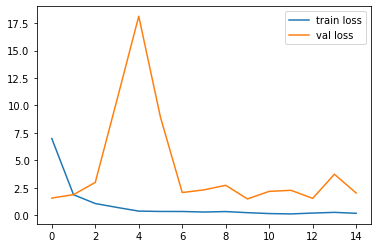

In [24]:
# loss
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='val loss')
plt.legend()
plt.show()

# We can see that the validation loss does not decrease smoothly from one epoch
# to the next. But, it does decrease overall.

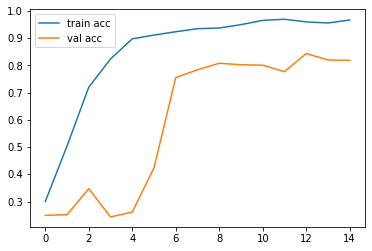

In [25]:
## accuracies
plt.plot(r.history['accuracy'], label='train acc')
plt.plot(r.history['val_accuracy'], label='val acc')
plt.legend()
plt.show()

# Again, we can see that the accuracy tends to fluctuate quite a bit.

In [26]:
model.load_weights(checkpoint_filepath)

#This gives us our best model during the training process as per the checkpoints

In [27]:
def get_confusion_matrix(data_path, N):
  # we need to see the data in the same order
  # for both predictions and targets
  print("Generating confusion matrix", N)
  predictions = []
  targets = []
  i = 0
  for x, y in val_gen.flow_from_directory(data_path, target_size=IMAGE_SIZE, shuffle=False, batch_size=batch_size * 2):
    i += 1
    if i % 50 == 0:
      print(i)
    p = model.predict(x)
    p = np.argmax(p, axis=1)
    y = np.argmax(y, axis=1)
    predictions = np.concatenate((predictions, p))
    targets = np.concatenate((targets, y))
    if len(targets) >= N:
      break

  cm = confusion_matrix(targets, predictions)
  return cm

In [28]:
cm = get_confusion_matrix(train_path, len(image_files))
print(cm)

Generating confusion matrix 9957
Found 9957 images belonging to 4 classes.
[[2231  113   49  104]
 [   0 2428   55    0]
 [   0  160 2318    0]
 [  27  128  123 2221]]


In [29]:
valid_cm = get_confusion_matrix(valid_path, len(valid_image_files))
print(valid_cm)

Generating confusion matrix 2487
Found 2487 images belonging to 4 classes.
[[477 114  22  10]
 [  0 609  11   0]
 [  0   0 506 114]
 [ 23  33  57 511]]


In [30]:
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
  """
  This function prints and plots the confusion matrix.
  Normalization can be applied by setting `normalize=True`.
  """
  if normalize:
      cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
      print("Normalized confusion matrix")
  else:
      print('Confusion matrix, without normalization')

  print(cm)

  plt.figure(figsize=(5,5))
  plt.imshow(cm, interpolation='nearest', cmap=cmap)
  plt.title(title)
  plt.colorbar()
  tick_marks = np.arange(len(classes))
  plt.xticks(tick_marks, classes, rotation=90)
  plt.yticks(tick_marks, classes)

  fmt = '.2f' if normalize else 'd'
  thresh = cm.max() / 2.
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
      plt.text(j, i, format(cm[i, j], fmt),
               horizontalalignment="center",
               color="white" if cm[i, j] > thresh else "black")

  plt.tight_layout()
  plt.ylabel('True label')
  plt.xlabel('Predicted label')
  plt.show()


def y2indicator(Y):
  K = len(set(Y))
  N = len(Y)
  I = np.empty((N, K))
  I[np.arange(N), Y] = 1
  return I

Confusion matrix, without normalization
[[2231  113   49  104]
 [   0 2428   55    0]
 [   0  160 2318    0]
 [  27  128  123 2221]]


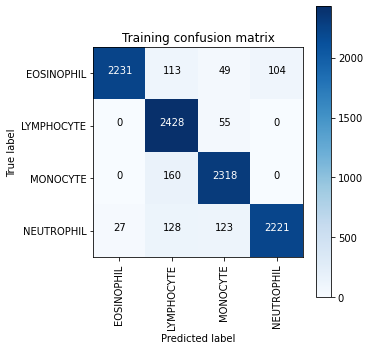

In [31]:
plot_confusion_matrix(cm, labels, title='Training confusion matrix')

In [32]:
# Now, we compute the accuracy for the training set from this confusion matrix
np.trace(cm) / cm.sum()

0.923772220548358

Confusion matrix, without normalization
[[477 114  22  10]
 [  0 609  11   0]
 [  0   0 506 114]
 [ 23  33  57 511]]


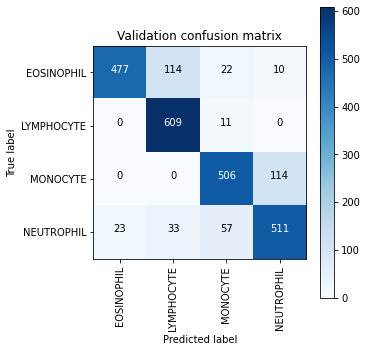

In [33]:
plot_confusion_matrix(valid_cm, labels, title='Validation confusion matrix')

In [34]:
# Now, we compute the accuracy for the test set from this confusion matrix
np.trace(valid_cm) / valid_cm.sum()

0.8455971049457177

So, we have gotten a decent accuracy on our dataset.